# Метод Штрассена

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from multiprocessing.pool import ThreadPool as pool

def generate_matrix(l, r, n):
    a = np.random.uniform(l, r, (n, n))
    return a

def print_matrix(a):
    for i in range(len(a)):
        print(a[i])

In [54]:
def ordinary_matrix_mul(matrix1, matrix2):
    rows_matrix1 = len(matrix1)
    cols_matrix1 = len(matrix1[0])
    cols_matrix2 = len(matrix2[0])
    rows_matrix2 = len(matrix2)

    if rows_matrix1 != cols_matrix2:
        return f'Ошибка: Не удается умножить матрицы, т.к. несовместимые размеры {rows_matrix1}x{cols_matrix1} и {rows_matrix2}x{cols_matrix2}'
    else:
        res = []
        for i in range(0, rows_matrix1):
            tmp = []
            for j in range(0, cols_matrix2):
                el = 0
                for k in range(cols_matrix1):
                    el += matrix1[i][k] * matrix2[k][j]
                tmp.append(el)
            res.append(tmp)
        return np.array(res)

def matrix_mul(a, b):
  n = len(a)
  m = len(b[0])
  l = len(b)

  c = [[0]*n for _ in range(m)]
  for i in range(n):
    for j in range(m):
      for k in range(l):
        c[i][j] += a[i][k] * b[k][j]
  return np.array(c)

In [49]:
def strassen(matrix1, matrix2):
  n = len(matrix1)
  if n <= 2:
    return np.dot(matrix1, matrix2)

  mid_row = n // 2
  mid_col = len(matrix1[0]) // 2
  A11 = matrix1[:mid_row, :mid_col]
  A12 = matrix1[:mid_row, mid_col:]
  A21 = matrix1[mid_row:, :mid_col]
  A22 = matrix1[mid_row:, mid_col:]

  mid_row = len(matrix2) // 2
  mid_col = len(matrix2[0]) // 2
  B11 = matrix2[:mid_row, :mid_col]
  B12 = matrix2[:mid_row, mid_col:]
  B21 = matrix2[mid_row:, :mid_col]
  B22 = matrix2[mid_row:, mid_col:]


  P1 = strassen(A11 + A22, B11 + B22)
  P2 = strassen(A21 + A22, B11)
  P3 = strassen(A11, B12 - B22)
  P4 = strassen(A22, B21 - B11)
  P5 = strassen(A11 + A12, B22)
  P6 = strassen(A21 - A11, B11 + B12)
  P7 = strassen(A12 - A22, B21 + B22)

  C11 = P1 + P4 - P5 + P7
  C12 = P3 + P5
  C21 = P2 + P4
  C22 = P1 - P2 + P3 + P6
  return np.vstack((np.hstack((C11, C12)), np.hstack((C21, C22 ))))

In [50]:
def strassen_multi(matrix1, matrix2):
  n = len(matrix1)
  if n <= 16:
    return np.dot(matrix1, matrix2)

  mid_row = n // 2
  mid_col = len(matrix1[0]) // 2
  A11 = matrix1[:mid_row, :mid_col]
  A12 = matrix1[:mid_row, mid_col:]
  A21 = matrix1[mid_row:, :mid_col]
  A22 = matrix1[mid_row:, mid_col:]

  mid_row = len(matrix2) // 2
  mid_col = len(matrix2[0]) // 2
  B11 = matrix2[:mid_row, :mid_col]
  B12 = matrix2[:mid_row, mid_col:]
  B21 = matrix2[mid_row:, :mid_col]
  B22 = matrix2[mid_row:, mid_col:]

  p = pool(processes=7)
  P1 = p.apply_async(strassen_multi, (A11 + A22, B11 + B22)).get()
  P2 = p.apply_async(strassen_multi, (A21 + A22, B11)).get()
  P3 = p.apply_async(strassen_multi, (A11, B12 - B22)).get()
  P4 = p.apply_async(strassen_multi, (A22, B21 - B11)).get()
  P5 = p.apply_async(strassen_multi, (A11 + A12, B22)).get()
  P6 = p.apply_async(strassen_multi, (A21 - A11, B11 + B12)).get()
  P7 = p.apply_async(strassen_multi, (A12 - A22, B21 + B22)).get()

  C11 = P1 + P4 - P5 + P7
  C12 = P3 + P5
  C21 = P2 + P4
  C22 = P1 - P2 + P3 + P6
  return np.vstack((np.hstack((C11, C12)), np.hstack((C21, C22 ))))

In [33]:
time1 = []
time2 = []
time3 = []
A = generate_matrix(-10, 10, 10)
B = generate_matrix(-10, 10, 10)
C = ordinary_matrix_mul(A, B)
print('\nordinary AxB:')
print_matrix(C)
C = strassen(A, B)
print('\nStrassen AxB:')
print_matrix(C)
C = strassen_multi(A, B)
print('\nStrassen with threads AxB:')
print_matrix(C)


ordinary AxB:
[  85.52646901  111.55674736  -57.34243226  169.66884075 -289.3655706
   30.75025022   40.62524545  -80.68824598  267.5053464   -58.56111557]
[ 146.80642335 -125.29596287  -88.72766516   70.92021073  144.56146566
   47.7127086    57.44399958  102.37947772  -92.80487247  -20.54795873]
[106.53427876 -14.36886285 -27.98182242 116.93853304   0.97455123
 193.64072019 165.2880519  -14.65764283  71.58510084 -69.90789484]
[ -44.43347136 -146.18184881   19.28650895  102.60380475  -63.03546471
   42.70829487  -39.80645062  172.94913381  133.04516633  -96.85756748]
[ 155.40328322 -139.31301974   22.46911015   57.05542287  108.93201582
  159.6086969   -32.16195171  -96.09951825  -36.07125362  -79.5355657 ]
[  20.39094868  121.90638656  -10.84359144 -138.81039479 -322.87311544
 -108.78265721   11.66026212  -13.73205108   41.71389026  192.14111199]
[-137.67457378   74.67330571   83.03159635   53.29434696 -164.34514576
 -157.0763711   -65.83764475    8.82252517  -52.49475606  -19.94418

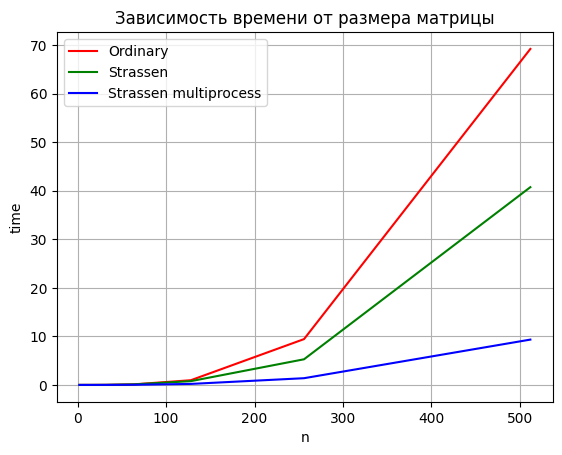

In [55]:
n = [2**i for i in range(1, 10)]
time1 = []
time2 = []
time3 = []

for dim in n:
  A = generate_matrix(-10, 10, dim)
  B = generate_matrix(-10, 10, dim)
  t = time.time()
  C = matrix_mul(A, B)
  tt = time.time()
  time1.append(tt - t)

  t = time.time()
  C = strassen(A, B)
  tt = time.time()
  time2.append(tt - t)

  t = time.time()
  C = strassen_multi(A, B)
  tt = time.time()
  time3.append(tt - t)

plt.title('Зависимость времени от размера матрицы')
plt.xlabel('n')
plt.ylabel('time')
plt.plot(n, time1, color='red', label='Ordinary')
plt.plot(n, time2, color='green', label='Strassen')
plt.plot(n, time3, color='blue', label='Strassen multiprocess')
plt.grid()
plt.legend()
plt.show()